In [1]:
import numpy as np
import classRiverSection as sect
import class1Dmodel as model

In [3]:
x=np.array( [0,5,63,93,100,200,206,230,260,294,300] , dtype=float)
y=np.array( [6, 3.5, 3.5, 3.5,  0,  0,  3, 3, 3, 3,  6] , dtype=float)
n=np.array([0.041, 0.041, 0.05, 0.030,0.030,0.030,0.040,0.05,0.040,0.040], dtype=float)

X = list( [x[0:3], x[2:4], x[3:7], x[6:8], x[7:9], x[8:]] )
Y = list( [y[0:3], y[2:4], y[3:7], y[6:8], y[7:9], y[8:]] )
N = list( [n[0:2], n[2:3], n[3:6], n[6:7], n[7:8], n[8:]] )

withTree = {
'treeh' : np.array([0, 1.5, 0, 0, 3.5, 0], dtype=float) # 樹高：分割断面数
,'subsectBoundf' : np.array([0, 0.1, 0.1, 0, 0.1, 0.1, 0], dtype=float) # 流れと樹木群の境界混合係数：分割断面数+1
,'subsectBoundfd' : np.array([0, 0.17, 0.17, 0.17, 0.17, 0.17, 0], dtype=float) # 流れ間の境界混合係数：分割断面数+1
    }

withoutTree = {
'treeh' : np.array([0, 0, 0, 0, 0, 0], dtype=float) # 樹高：分割断面数
,'subsectBoundf' : np.array([0, 0, 0, 0, 0, 0, 0], dtype=float) # 流れと樹木群の境界混合係数：分割断面数+1
,'subsectBoundfd' : np.array([0, 0, 0.17, 0.17, 0, 0, 0], dtype=float) # 流れ間の境界混合係数：分割断面数+1
    }

dx = 200
Ls = np.arange(0,15001,dx) 

csections = []
# csections = List()
s = sect.section(X, Y, N, Ls[0], **withoutTree)
csections.append(s)

yold = y.copy()
ibs = []
ibs.append(1/2000)
for L in Ls[1:]:
    if L < 5000:
        ib = 1/2000
    elif L < 10000:
        ib = 1/1000
    else:
        ib = 1/500
        
    y = yold + dx*ib
    Y = list([y[0:3], y[2:4], y[3:7], y[6:8], y[7:9], y[8:]])
    
    if 2000 <= L < 4000:
        s = sect.section(X, Y, N, L, **withTree)
    elif 12000 <= L < 14000:
        s = sect.section(X, Y, N, L, **withTree)
    else:
        s = sect.section(X, Y, N, L, **withoutTree)
    
    csections.append(s)
    
    yold = y.copy()
    ibs.append(ib)

In [4]:
def UnSteadyflow(sections, Q, H, A, Qbound, Hbound, dt):
    g = float(9.8)
    imax = len(Q)
    Anew, Qnew, Hnew = np.zeros(imax), np.zeros(imax), np.zeros(imax)
    ie = np.zeros(imax)
    Beta = np.zeros(imax)
    
# continuous equation
    for i in range(1, imax-1) : 
        dx = 0.5*(sections[i-1].distance - sections[i+1].distance)
        Anew[i] = A[i] - dt * ( Q[i] - Q[i-1] ) / dx
        
    s = sections[imax-1]
    Ad,_,_,_,_ = s.H2ABSKRc(Hbound)
    Anew[imax-1] = Ad
    Anew[0] = Anew[1]
#     Anew[0] = (Anew[1] - A[1]) + A[0]
    
    for i in range(imax) : 
        s = sections[i]
        Hnew[i] = s.A2H(Anew[i])
        ie[i], _, Beta[i], _= s.HQ2IeAlphaBetaVsub(H[i], Q[i])        
    
# moumentum equation
    for i in range(1, imax-1): 
        ic, im, ip = i, i-1, i+1
        dxp = sections[ic].distance - sections[ip].distance
        dxm = sections[im].distance - sections[ic].distance
        dxc = 0.5*(sections[im].distance - sections[ip].distance)
        
        Cr1 = 0.5*( Q[ic]/A[ic] + Q[ip]/A[ip] )*dt/dxp
        Cr2 = 0.5*( Q[ic]/A[ic] + Q[im]/A[im] )*dt/dxm
        dHdx1 = ( Hnew[ip] - Hnew[ic] ) / dxp
        dHdx2 = ( Hnew[ic] - Hnew[im] ) / dxm
        dHdx = (float(1.0) - Cr1) * dHdx1 + Cr2 * dHdx2
        
        Qnew[ic] = Q[ic] - dt * ( Beta[ic]*Q[ic]**2/A[ic] - Beta[im]*Q[im]**2/A[im] ) / dxc \
                         - dt * g * Anew[ic] * dHdx \
                         - dt * g * A[ic] * ie[ic] 
        
    Qnew[imax-1] = Qnew[imax-2]
    Qnew[0] = Qbound
        
    return Qnew, Hnew, Anew

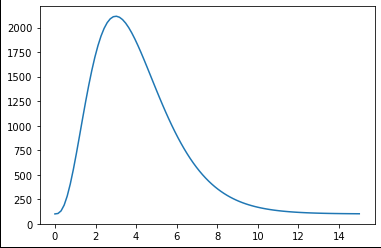

In [5]:
import matplotlib.pyplot as plt

gamma = lambda t,z : t**(z-1)*np.exp(-t)

L = np.linspace(0,15,100)
Qupt = 1500*gamma(L,4)+100

plt.figure(facecolor="white", edgecolor="black", linewidth=2)
plt.plot(L,Qupt)
plt.show()

In [6]:
dt = float(10)
t = np.arange(0,15*3600,dt)
Qupts = np.interp(t, L*3600, Qupt)

In [7]:
Qup = Qupts[0]
ib = float(1/2000)
# 下流端水位
s = csections[0]
Hd = s.H0(Qup, ib)
H = model.nonuniform(csections, Qup, Hd)

A = np.zeros_like(H)
for i, s in enumerate(csections):
    A[i],_,_,_,_ = s.H2ABSKRc(H[i])

In [8]:
%%time
rcsections = list(reversed(csections))

Qc  = np.full_like(H,Qup)
Hc = H[::-1]
Ac = A[::-1]

Qout = np.zeros((len(Qupts), len(Qc)))
Hout = np.zeros_like(Qout)

Qout[0] = Qc
Hout[0] = Hc

for n in range(1, len(Qupts)):
    s = rcsections[-1]
    Hd = s.H0(Qc[-1], ib)
    Qc, Hc, Ac = UnSteadyflow(rcsections, Qc, Hc, Ac, Qupts[n], Hd, dt)

    Qout[n] = Qc
    Hout[n] = Hc

Wall time: 4min 21s
